### **Import Package**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import datetime as dt

### **Import Data**

In [2]:
df = pd.read_csv('Online Retail Data.csv', header=0)
pd.set_option('display.max_column',None)
df.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1,2010-01-04 09:54:00,3.75,NaN


### **Eksplorasi Data**

In [3]:
# Cek struktur data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461773 entries, 0 to 461772
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      461773 non-null  object 
 1   product_code  461773 non-null  object 
 2   product_name  459055 non-null  object 
 3   quantity      461773 non-null  int64  
 4   order_date    461773 non-null  object 
 5   price         461773 non-null  float64
 6   customer_id   360853 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 24.7+ MB


In [4]:
# Cek statistika deskriptif
df.describe().round(2)

,quantity,price,customer_id
count,461773.00,461773.00,360853.00
mean,9.09,4.57,15557.61
std,86.37,153.41,1593.73
min,-9600.00,-53594.36,12346.00
25%,1.00,1.25,14210.00
50%,3.00,2.10,15580.00
75%,10.00,4.21,16938.00
max,10200.00,25111.09,18287.00


In [5]:
# Cek missing value
df.isnull().sum()

,0
order_id,0
product_code,0
product_name,2718
quantity,0
order_date,0
price,0
customer_id,100920


In [6]:
# Cek data duplicate
df.duplicated().sum()

np.int64(6479)

In [7]:
# Cek konsistensi nilai (duplikasi product_name untuk product_code yang sama)
desc_consistency = df.groupby('product_code')['product_name'].nunique().sort_values(ascending=False)
desc_consistency.head()

,product_name
product_code,
22423,6
22734,6
21523,4
21843,4
47566B,4


In [8]:
# Melihat duplikasi product_name untuk product_code "22423"
df.loc[df['product_code'] == '22423', 'product_name'].unique().tolist()

['REGENCY CAKESTAND 3 TIER',
 'smashed',
 'damaged',
 nan,
 'broken, uneven bottom',
 'wonky bottom/broken',
 'faulty']

### **Data Cleansing**

In [9]:
# Salin dataframe untuk pembersihan data
df_clean = df.copy()

In [10]:
# Menghapus semua baris tanpa customer_id
df_clean = df_clean[~df_clean['customer_id'].isna()]
# Menghapus semua baris tanpa product_name
df_clean = df_clean[~df_clean['product_name'].isna()]

In [11]:
# Mengubah customer_id ke format string
df_clean['customer_id'] = df['customer_id'].astype(str)
# Mengubah order_date ke format datetime
df_clean['order_date'] = pd.to_datetime(df_clean['order_date'])
# Membuat product_name berhuruf kecil
df_clean['product_name'] = df_clean['product_name'].str.lower()

In [12]:
# Menghapus nilai quantity negatif dan order_id yg diawali 'C' karena menandakan order "Cancelled"
df_clean.drop(df_clean[df_clean['quantity'] <= 0].index, inplace = True)
df_clean = df_clean[df_clean['order_id'].str[:1]!='C']
# Menghapus semua baris dengan price <= 0
df_clean.drop(df_clean[df_clean['price'] <= 0].index, inplace = True)
# Menghapus semua baris dengan product_code atau product_name test
df_clean = df_clean[(~df_clean['product_code'].str.lower().str.contains('test')) |
                    (~df_clean['product_name'].str.contains('test'))]

In [13]:
# Mengganti product_name dari product_code yang memiliki beberapa product_name dengan salah satu product_name-nya yang paling sering muncul
most_freq_product_name = df_clean.groupby(['product_code','product_name'], as_index=False).agg(order_cnt=('order_id','nunique')).sort_values(['product_code','order_cnt'], ascending=[True,False])
most_freq_product_name['rank'] = most_freq_product_name.groupby('product_code')['order_cnt'].rank(method='first', ascending=False)
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank']==1].drop(columns=['order_cnt','rank'])
df_clean = df_clean.merge(most_freq_product_name.rename(columns={'product_name':'most_freq_product_name'}), how='left', on='product_code')
df_clean['product_name'] = df_clean['most_freq_product_name']
df_clean = df_clean.drop(columns='most_freq_product_name')

In [14]:
# Membuat kolom amount, yaitu hasil kali antara quantity dan price
df_clean['amount'] = df_clean['quantity'] * df_clean['price']
# Membuat kolom year-month
df_clean['year_month'] = df_clean['order_date'].dt.to_period('M')

In [15]:
# Menghapus data duplicate
df_clean = df_clean.drop_duplicates()
df_clean.duplicated().sum()

np.int64(0)

In [16]:
# Menghapus outlier
from scipy import stats
df_clean = df_clean[(np.abs(stats.zscore(df_clean[['quantity','amount']]))<3).all(axis=1)]
df_clean = df_clean.reset_index(drop=True)

In [17]:
# product_code yang diawali dengan angka menunjukan kode produk, sementara
# product_code khusus seperti 'POST', 'D', dan 'M mewakili transaksi non-produk (jasa, penyesuaian, dll.)
# Analisis hanya berfokus pada transaksi produk (tanpa melibatkan data transaksi non produk)
df_clean = df_clean[df_clean['product_code'].str.match(r'^\d', na=False)]

df_clean.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id,amount,year_month
0,493414,21844,red retrospot mug,36,2010-01-04 10:28:00,2.55,14590.0,91.8,2010-01
1,493414,21533,retro spot large milk jug,12,2010-01-04 10:28:00,4.25,14590.0,51.0,2010-01
2,493414,37508,new england ceramic cake server,2,2010-01-04 10:28:00,2.55,14590.0,5.1,2010-01
3,493414,35001G,hand open shape gold,2,2010-01-04 10:28:00,4.25,14590.0,8.5,2010-01
4,493414,21527,red retrospot traditional teapot,12,2010-01-04 10:28:00,6.95,14590.0,83.4,2010-01


In [18]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 343390 entries, 0 to 343818
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      343390 non-null  object        
 1   product_code  343390 non-null  object        
 2   product_name  343390 non-null  object        
 3   quantity      343390 non-null  int64         
 4   order_date    343390 non-null  datetime64[ns]
 5   price         343390 non-null  float64       
 6   customer_id   343390 non-null  object        
 7   amount        343390 non-null  float64       
 8   year_month    343390 non-null  period[M]     
dtypes: datetime64[ns](1), float64(2), int64(1), object(4), period[M](1)
memory usage: 26.2+ MB


### **User Retention: Cohort Analysis**

In [19]:
# Simpan dataframe yang telah dibersihkan
df_clean.to_csv('Online Retail Data (Clean).csv', index=False, float_format="%.3f")

#####**Agregat data transaksi ke bentuk summary total transaksi setiap customer setiap bulan**

In [21]:
df_user_monthly = df_clean.groupby(['customer_id','year_month'], as_index=False).agg(order_cnt=('order_date','nunique'))
df_user_monthly

,customer_id,year_month,order_cnt
0,12346.0,2010-03,1
1,12346.0,2010-06,1
2,12608.0,2010-10,1
3,12745.0,2010-05,1
4,12745.0,2010-08,1
...,...,...,...
11343,18285.0,2010-02,1
11344,18286.0,2010-08,1
11345,18287.0,2010-05,1
11346,18287.0,2010-09,2


#####**Membuat kolom cohort untuk setiap customer, yakni tahun-bulan pertama kali customer bertransaksi**

In [22]:
df_user_monthly['cohort'] = df_user_monthly.groupby('customer_id')['year_month'].transform('min')
df_user_monthly

,customer_id,year_month,order_cnt,cohort
0,12346.0,2010-03,1,2010-03
1,12346.0,2010-06,1,2010-03
2,12608.0,2010-10,1,2010-10
3,12745.0,2010-05,1,2010-05
4,12745.0,2010-08,1,2010-05
...,...,...,...,...
11343,18285.0,2010-02,1,2010-02
11344,18286.0,2010-08,1,2010-08
11345,18287.0,2010-05,1,2010-05
11346,18287.0,2010-09,2,2010-05


#####**Menghitung jarak bulan antara bulan transaksi dengan bulan pertama kali transaksi dan menjumlahkannya dengan 1**

In [23]:
from operator import attrgetter

df_user_monthly['period_num'] = (df_user_monthly['year_month'] - df_user_monthly['cohort']).apply(attrgetter('n')) + 1
df_user_monthly

,customer_id,year_month,order_cnt,cohort,period_num
0,12346.0,2010-03,1,2010-03,1
1,12346.0,2010-06,1,2010-03,4
2,12608.0,2010-10,1,2010-10,1
3,12745.0,2010-05,1,2010-05,1
4,12745.0,2010-08,1,2010-05,4
...,...,...,...,...,...
11343,18285.0,2010-02,1,2010-02,1
11344,18286.0,2010-08,1,2010-08,1
11345,18287.0,2010-05,1,2010-05,1
11346,18287.0,2010-09,2,2010-05,5


#####**Membuat tabel pivot dengan index cohort, kolom jarak bulan, dan nilainya adalah banyaknya customer unik**

In [24]:
df_cohort_pivot = pd.pivot_table(df_user_monthly, index='cohort', columns='period_num', values='customer_id', aggfunc=pd.Series.nunique)
df_cohort_pivot

period_num,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2010-01,648.0,236.0,310.0,284.0,256.0,277.0,260.0,245.0,249.0,278.0,303.0,228.0
2010-02,470.0,132.0,127.0,156.0,144.0,121.0,110.0,164.0,151.0,163.0,97.0,NaN
2010-03,529.0,124.0,138.0,143.0,129.0,120.0,142.0,184.0,181.0,89.0,NaN,NaN
2010-04,326.0,66.0,72.0,63.0,63.0,74.0,97.0,99.0,47.0,NaN,NaN,NaN
2010-05,273.0,46.0,51.0,49.0,48.0,71.0,67.0,43.0,NaN,NaN,NaN,NaN
2010-06,263.0,43.0,52.0,59.0,65.0,81.0,37.0,NaN,NaN,NaN,NaN,NaN
2010-07,180.0,28.0,33.0,51.0,51.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,165.0,32.0,47.0,51.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,224.0,52.0,54.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#####**Menghitung banyaknya first customer di masing-masing cohort**

In [25]:
cohort_size = df_cohort_pivot.iloc[:, 0]
cohort_size

,1
cohort,
2010-01,648.0
2010-02,470.0
2010-03,529.0
2010-04,326.0
2010-05,273.0
2010-06,263.0
2010-07,180.0
2010-08,165.0
2010-09,224.0


#####**Membuat Tabel Cohort**

In [26]:
df_retention_cohort = df_cohort_pivot.divide(cohort_size, axis=0)
df_retention_cohort

period_num,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2010-01,1.0,0.364198,0.478395,0.438272,0.395062,0.427469,0.401235,0.378086,0.384259,0.429012,0.467593,0.351852
2010-02,1.0,0.280851,0.270213,0.331915,0.306383,0.257447,0.234043,0.348936,0.321277,0.346809,0.206383,NaN
2010-03,1.0,0.234405,0.260870,0.270321,0.243856,0.226843,0.268431,0.347826,0.342155,0.168242,NaN,NaN
2010-04,1.0,0.202454,0.220859,0.193252,0.193252,0.226994,0.297546,0.303681,0.144172,NaN,NaN,NaN
2010-05,1.0,0.168498,0.186813,0.179487,0.175824,0.260073,0.245421,0.157509,NaN,NaN,NaN,NaN
2010-06,1.0,0.163498,0.197719,0.224335,0.247148,0.307985,0.140684,NaN,NaN,NaN,NaN,NaN
2010-07,1.0,0.155556,0.183333,0.283333,0.283333,0.150000,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,1.0,0.193939,0.284848,0.309091,0.157576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,1.0,0.232143,0.241071,0.129464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Visualisasi**

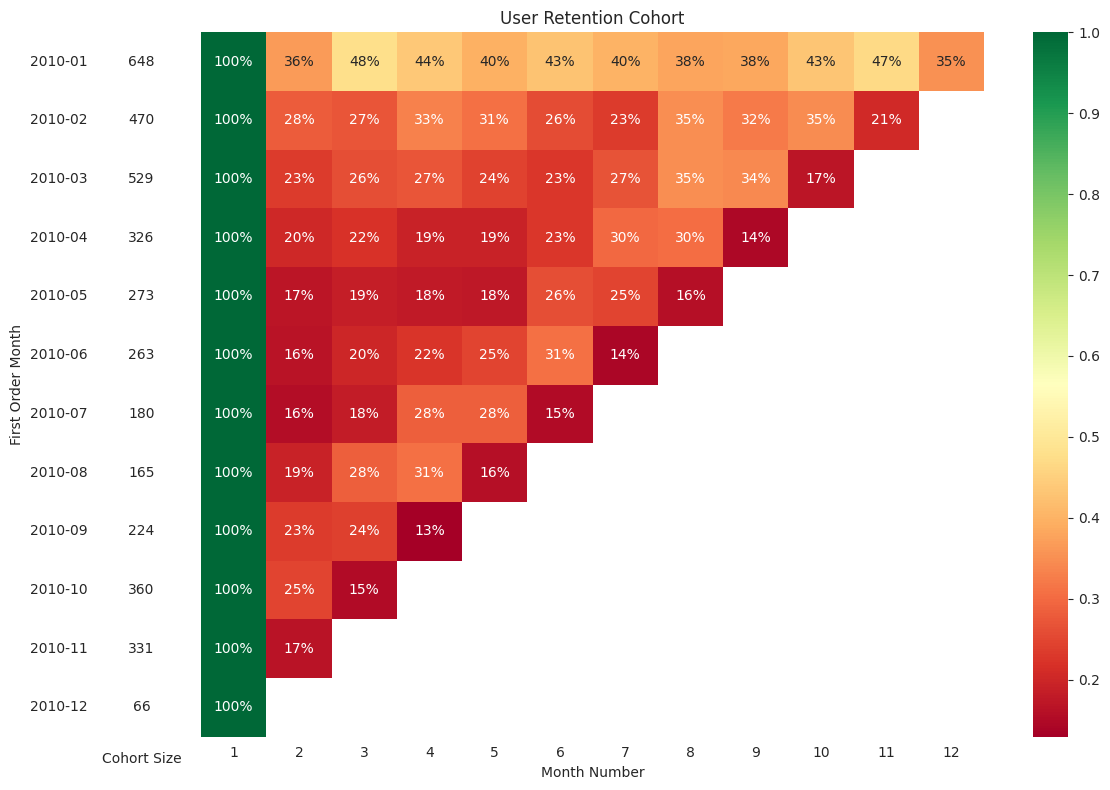

In [27]:
with sns.axes_style('white'):

    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios':[1, 11]})

    # user retention cohort
    sns.heatmap(df_retention_cohort, annot=True, fmt='.0%', cmap='RdYlGn', ax=ax[1])
    ax[1].set_title('User Retention Cohort')
    ax[1].set(xlabel='Month Number', ylabel='')

    # cohort size
    df_cohort_size = pd.DataFrame(cohort_size)
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(df_cohort_size, annot=True, cbar=False, fmt='g', cmap=white_cmap, ax=ax[0])
    ax[0].tick_params(bottom=False)
    ax[0].set(xlabel='Cohort Size', ylabel='First Order Month', xticklabels=[])

    fig.tight_layout()